<a href="https://colab.research.google.com/github/hyperiondroid/py-ppg/blob/master/py-ppg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import signal

# imshow() patch for Jupyter notebooks
from google.colab.patches import cv2_imshow

# Known Constants
I_CAP_PATH = '/content/drive/MyDrive/Colab Notebooks/Smartphone-based PPG/dataset/t1.mp4'
# Load finger video capture
i_cap = cv2.VideoCapture(I_CAP_PATH)

# Input video capture FPS
CAP_FPS = round(i_cap.get(cv2.CAP_PROP_FPS))
CAP_LEN = int(i_cap.get(cv2.CAP_PROP_FRAME_WIDTH ))
CAP_WID = int(i_cap.get(cv2.CAP_PROP_FRAME_HEIGHT ))

# Get total number of frames
num_frames = int(i_cap.get(cv2.CAP_PROP_FRAME_COUNT))

print('Capture: <fps:{}> <resolution:{}x{}>'.format(CAP_FPS,CAP_LEN,CAP_WID))

# Configure parameters
# Set sampling FPS such that (CAP_FPS % FPS == 0) (Ex: 15, 10, 6 etc.)
config_fps = CAP_FPS / 2
# Set config Resolution scale (Direct multiplier)
config_res_scale = 0.5

print('Processing: <fps:{}> <resolution:{}x{}>'.
      format(int(config_fps), int(CAP_LEN * config_res_scale),int(CAP_WID*config_res_scale)))

# Plot local maximas for a given signal as 1D series
def get_peaks(y_red):
  peaks, _ = signal.find_peaks(y_red, height=0)
  return peaks

def lowpass_butterworth_filter(data):
  # Cuttoff frequenzy is 3Hz (180bpm)
  cutoff = 3
  # Nyquist Frequency
  nyq = 0.5 * config_fps
  # Order of signal (sine curve ~ quadratic)
  order = 2 
  normal_cutoff = min(0.999999, cutoff / nyq)

  b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
  y = signal.filtfilt(b, a, data)
  return y

# Process frame to extract mean red intensity in the frame
def process(frame):
  len, wid, ch = frame.shape
  frame_scaled = cv2.resize(frame, (int(config_res_scale * len),int(config_res_scale * wid)))

  # Apply Gaussian blur to smooth
  gaus_frame = cv2.GaussianBlur(frame_scaled,(5,5),0)

  length, width, channels = gaus_frame.shape
  return np.sum(gaus_frame[:,:,2])/(length*width)


# Initialize array for red intensity values for y-axis
# y_red = np.zeros(num_frames)
y_red = np.array([])

# Initialise time array and step count for x-axis
x_time = []
step = 1/config_fps

# Support only integer sampling. (30/15/10/5 fps)
sample_rate = CAP_FPS/config_fps

# Start iterating - Replacing read with grab() for performance
# ret, frame = i_cap.read()
ret = i_cap.grab()

cur_frame = 0
cur_time = 0.0

while ret:
  if cur_frame % sample_rate == 0:

    # Retrieve if just grabbed and not read()
    _, frame = i_cap.retrieve()

    # Update y with processed red intensity
    red_val = process(frame)
    y_red = np.append(y_red, red_val)

    # Update x with time
    x_time.append(cur_time)

  # Loop to next frame - Replacing read() with grab/retrieve for performance
  # ret, frame = i_cap.read()
  ret = i_cap.grab()
  cur_frame += 1
  cur_time += step


Capture: <fps:30> <resolution:2160x3840>
Processing: <fps:15> <resolution:1080x1920>


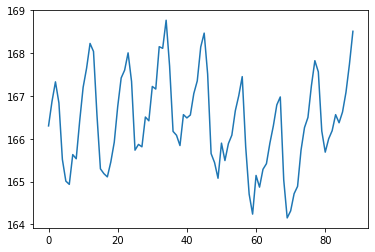

In [11]:
plt.plot(y_red)

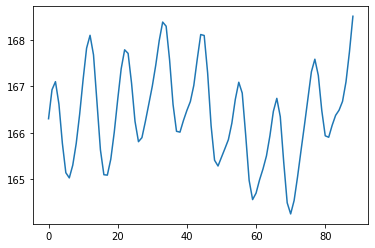

In [12]:
y_red_flt = lowpass_butterworth_filter(y_red)
plt.plot(y_red_flt)

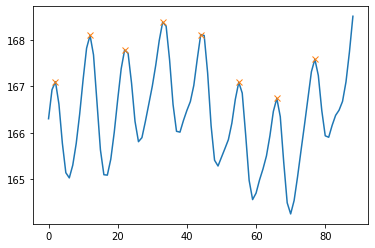

In [13]:
peaks = get_peaks(y_red_flt)
plt.plot(y_red_flt)
plt.plot(peaks, y_red_flt[peaks], "x")

In [14]:
# Naive: Counting number of local maximas on lowpass filtered signal

print(len(peaks), num_frames, CAP_FPS)
heart_freq_n = round((len(peaks))/(num_frames / CAP_FPS),2)
bpm_n = round(heart_freq_n * 60)
print('Frequency of Heart: {}Hz'.format(heart_freq_n))
print('BPM: {}'.format(bpm_n))

8 178 30
Frequency of Heart: 1.35Hz
BPM: 81


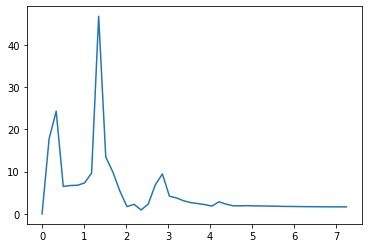

In [15]:
# Use DFT to estimate frequency

# Detrend the signal to fix huge peak at 0Hz
y_red_dt = signal.detrend(y_red_flt)

# Compute (FFT : y) and (frequency bins : x)
Y    = np.fft.fft(y_red_dt)
freq = np.fft.fftfreq(len(y_red)) * config_fps

# Extract only positive frequency dist. (Second half of the ndarray)
freq = freq[:len(freq)//2]
Y = Y[:len(Y)//2]

# Plot FFT against frequency
plt.plot( freq, np.abs(Y) )

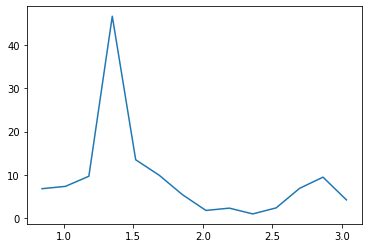

In [17]:
# Locate maximum frequency in target frequency (1Hz-3Hz ~ 60-180bpm)
MIN_FREQ = 1 # 60bpm
MAX_FREQ = 3 # 180bpm
freq_step = freq[1] - freq[0]
min_freq_index = int(MIN_FREQ / freq_step) 
max_freq_index = int(MAX_FREQ / freq_step) + 1

filtered_freq = freq[min_freq_index: max_freq_index + 1]
filtered_Y = Y[min_freq_index: max_freq_index + 1]

plt.plot( filtered_freq, np.abs(filtered_Y) )


In [18]:
# Calculate BPM with filtered frequency
heart_freq_f = round(filtered_freq[np.argmax(np.abs(filtered_Y))], 2)
bpm_f = round(heart_freq_f * 60)

print('Frequency of Heart: {}Hz'.format(heart_freq_f))
print('BPM: {}'.format(bpm_f))

Frequency of Heart: 1.35Hz
BPM: 81
